# RQ1 mutation map

We analyze the mutators in wasm-mutate as features. For example, the `CodemotionMutator` has two possible mutations, one, to unroll a loop, two, to invert an if construction. By enabling `code_motion_loops` we will only get information about the mutability of the modules only taking into account the loops in the binary.


## To what extent the sota benchmark is mutable according to wasm-mutate?


In [7]:
# Example about how to compile wasm-mutate with a specific feature and how to call the metada extraction
! cd ../analyzer && cargo build --features wasm-mutate/add_function
! ../analyzer/target/debug/analyzer  admin admin extract -r -d 1 --input  ../analyzer/tests

 --> /Users/javierca/Documents/Develop/new_obfuscation_paper/wasm-tools/crates/wasm-mutate/src/mutators/codemotion/loop_unrolling.rs:3:46
  |
3 | use std::{collections::HashMap, slice::Iter, iter::empty};
  |                                              ^^^^^^^^^^^
  |
  = note: `#[warn(unused_imports)]` on by default

   --> /Users/javierca/Documents/Develop/new_obfuscation_paper/wasm-tools/crates/wasm-mutate/src/mutators/codemotion.rs:198:9
    |
198 |         'functions: for fidx in 0..function_count {
    |         ^^^^^^^^^^
    |
    = note: `#[warn(unused_labels)]` on by default

 --> /Users/javierca/Documents/Develop/new_obfuscation_paper/wasm-tools/crates/wasm-mutate/src/mutators/custom.rs:6:20
  |
6 | use wasm_encoder::{CodeSection, SectionId};
  |                    ^^^^^^^^^^^

  --> /Users/javierca/Documents/Develop/new_obfuscation_paper/wasm-tools/crates/wasm-mutate/src/mutators/peephole.rs:43:45
   |
43 | use std::{ops::Range, collections::HashMap, hash::Hash, cmp::max};

[2022-08-01T11:46:22Z ERROR analyzer::subcommands::extract] 
    Just discard "../analyzer/tests/test2.zip"
    
^C


### Insights

- A binary can always be mutated by adding a new type definition
- To add a bogus function, the binary needs to have a code section, therefore, only 97.29% of the cases can. The remaining 2.71% of the binaries in the while (unfiltered) has no code section. This is probably due to the presence of test suites
- In 96.59% of the cases a peephole mutator can be applied (the same for the code motion). However, this figure takes into account only the high level validation of the mutator. For example, the code mutator only checks for local defined functions. Thus, we need to go deeper and evaluate how many of the instructions per module (% could be) can be in practice parsed and replaced in the relying egraphs. The same for the code mutator.

- The RemoveSection:Custom can be applied to 62.74% of the binaries. This means, that this mutator can be applied without interfiring with the execution of the binary at all. Usually custom sections only appear to provide debug information, such as function names. This leads us to apply reduce to the dataset to evaluate if in fact even after the manual filtering it still be biased by natural obfuscation.

- On the other hand, some mutation can be applied but the generated module could be invalid and thats how wasm-mutate validates the binary. For example, the remove global mutator can be applied, but only at the validation stage, we could notice if the removed global was used or not.

- Interesting, all binaries in the filtered dataset have code section, therefore, we can apply the peephole mutator to all
- Still, RemoveCustomSection can be applied in 32% of the cases. The dataset is probably biased
    - (Insight1)After, some experiments, the reduction works for less than 1% of the cases, therefore the manual filtering is consistent


In [105]:
!ls -lah


total 146752
drwxr-xr-x  30 javierca  staff   960B  2 Aug 07:44 .
drwxr-xr-x@ 15 javierca  staff   480B  1 Aug 12:24 ..
-rw-r--r--@  1 javierca  staff   6.0K  1 Aug 15:22 .DS_Store
drwxr-xr-x   4 javierca  staff   128B 29 Jul 20:01 .ipynb_checkpoints
-rw-r--r--   1 javierca  staff    74K  2 Aug 07:44 Mutation map.ipynb
-rw-r--r--   1 javierca  staff   254K  1 Aug 18:32 RQ1.ipynb
drwxr-xr-x   3 javierca  staff    96B 29 Jul 20:01 __pycache__
-rw-r--r--   1 javierca  staff   595K  1 Aug 21:08 add_function.csv
-rw-r--r--   1 javierca  staff   595K  1 Aug 21:08 add_type.csv
-rw-r--r--   1 javierca  staff    59K  1 Aug 18:31 all.csv
-rw-r--r--   1 javierca  staff   588K  1 Aug 21:26 code_motion_ifs.csv
-rw-r--r--   1 javierca  staff   595K  1 Aug 21:33 code_motion_loops.csv
-rw-r--r--   1 javierca  staff   595K  1 Aug 17:58 custom_names.csv
-rw-r--r--   1 javierca  staff    41M 29 Jul 15:41 filtered.json
-rw-r--r--   1 javierca  staff   595K  1 Aug 21:33 function_body_unreachable.csv
-rw-r

In [111]:
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import json
import pandas as pd

def load_mutable_csv(f, rename=""):
    a = pd.read_csv(f,index_col = 'id')
    
    if rename:
        a.rename(columns = {'mutable_count': rename}, inplace = True)
    
    #display(a)
    return a

ratios = [
    
]

files = (
    [ "codemotion_loops", "code_motion_loops.csv" ],
    [ "codemotion_ifs", "code_motion_ifs.csv" ],
    [ "modify_custom_section_data", "modify_custom_section_data.csv" ],
    [ "remove_exports", "remove_exports.csv" ],
    #[ "remove_function", "remove_function.csv" ],
    [ "remove_item_function", "remove_item_function.csv" ],
    [ "snip_function", "snip_function.csv" ],
    [ "modify_data", "modify_data.csv" ],
)
alldf = pd.DataFrame()

for n, f in files:
    df = load_mutable_csv(f, n)
    alldf = pd.concat([df, alldf], axis=1)

# Remove rows with Nan value
alldf=alldf.dropna()

display(alldf)

alldf.to_csv("all.csv")

print(ratios)

,modify_data,snip_function,remove_item_function,remove_exports,modify_custom_section_data,codemotion_ifs,codemotion_loops
id,,,,,,,
037508f80827befd9503a3b2644d82cedf7f7f1b115552879e6c8c2542e62bb2.wasm,0,0,1.0,0,0,0.0,1
6598704854b38b6529809330fbb1feea8f99c3f76daf97ed1d08824436552502.wasm,0,0,0.0,0,1,0.0,1
16b1969b1a2ca510f217825d237420d162bab499d5b9b62bed64d69d144a4e8d.wasm,0,0,0.0,0,0,1.0,1
88caada29815c4ee299603a7d1f52037d1dd0ae56779a368c91a6c6c8405498f.wasm,0,0,0.0,0,0,1.0,1
7a7e2f32261fca6e59781183768a782947feb547095f784d4ddcd560d02ee54c.wasm,0,0,0.0,0,0,1.0,1
...,...,...,...,...,...,...,...
ec79a9f9282a517b0c25afc8652dfd216b62636d1181c48ee8d8546ad112157c.wasm,0,0,1.0,0,0,0.0,1
c46e332b470498643fadd1d598b0285bd44c1f60204321ad4c01a5a3a5e22338.wasm,0,0,0.0,0,0,0.0,1
115bb6160846deccb7cf0204c4430082db5e519c2f60d9268beacf07468ae9c6.wasm,0,0,0.0,0,0,0.0,1


[]


[('codemotion_loops', 94.53237410071942), ('codemotion_ifs', 32.0863309352518), ('modify_custom_section_data', 31.07913669064748), ('remove_exports', 0.0), ('remove_item_function', 33.52517985611511), ('snip_function', 0.0), ('modify_data', 0.0)]


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

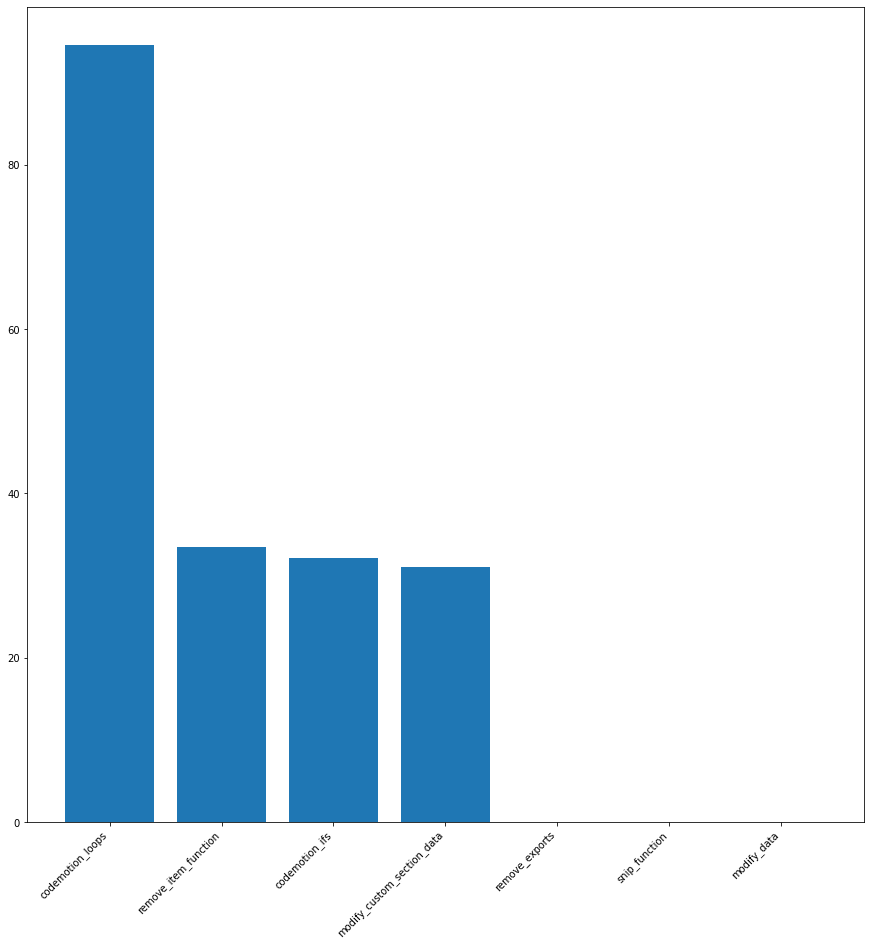

In [112]:
# import and set figure size
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]

total = len(alldf)
ratios = [ (x, 100*sum(alldf[alldf[x] > 0][x])/total) for x in [y[0] for y in files] ]

print(ratios)
ratios = sorted(ratios, key= lambda x: x[1], reverse=True)

plt.bar([
    x[0] for x in ratios
], [x[1] for x in ratios])
plt.xticks(rotation=45, ha='right')



## Fine-grained checking of mutability

In [7]:
sets, total = load_sets("filtered_d2.json", find_mutation_info = True,only_index = False )
print(len(sets), total)
#print(sets[1][1])

PeepholeMutator::new(10) 178
AddTypeMutator { max_params: 20, max_results: 20 } 178
AddFunctionMutator 178
RemoveItemMutator(Item::Function) 178
RemoveItemMutator(Item::Memory) 175
RemoveItemMutator(Item::Table) 156
RemoveItemMutator(Item::Type) 178
CodemotionMutator 172
RemoveSection::Custom 55
RemoveItemMutator(Item::Global) 127
CustomSectionMutator 55
RemoveSection::Empty 3
12 178


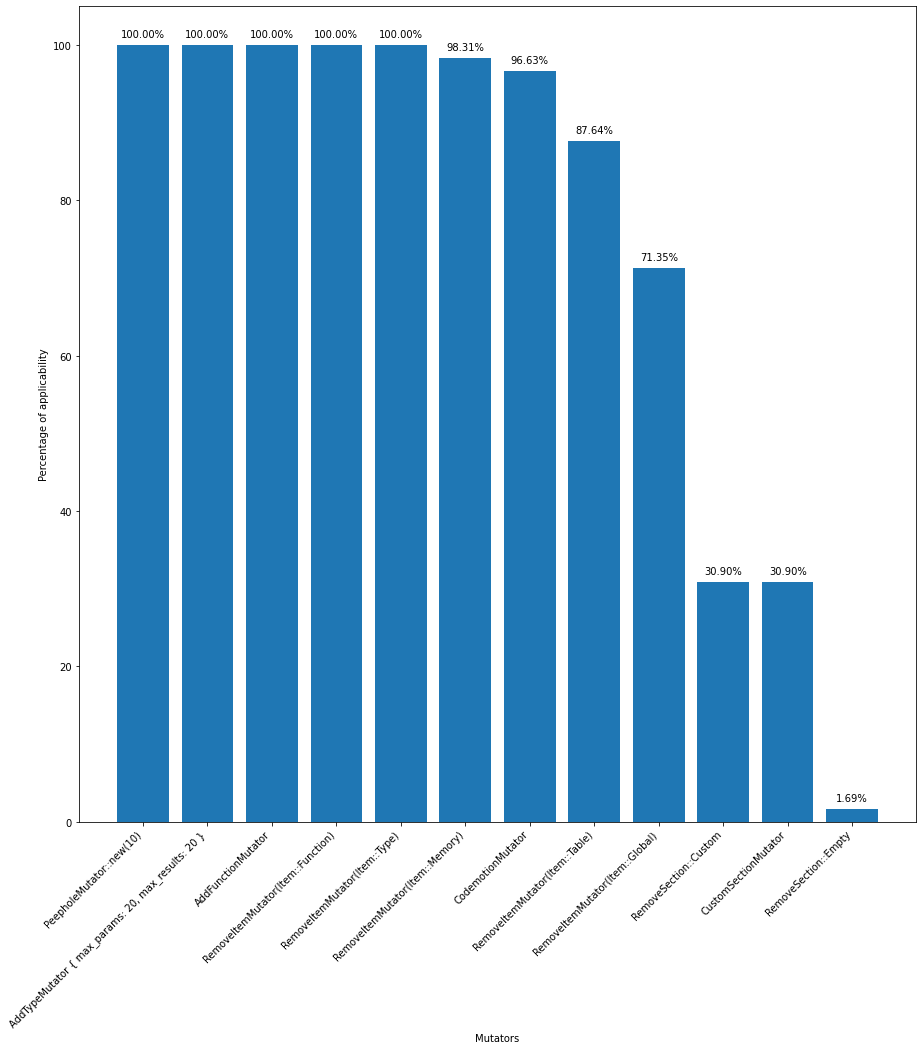

In [8]:
plot_bars(sets, total)

The previous figure can lead us to create the correct sort of 'configuration sets' according to the 'Swarm testing paper'

In [ ]:
import numpy as np

peep = sets[0]
randombin = peep[1][0]

print("Id", randombin['id'])

print(randombin['mutations'][0]['class_name'])
# List how the mutation can be applied
print(list(randombin['mutations'][0]['map'].values())[0][0]['how'])

operators_count = randombin['num_instructions']
mutations_count = len(randombin['mutations'][0]['map'].values())
peephole_mutability = mutations_count/operators_count

print(operators_count, mutations_count, peephole_mutability)

# get all posible peephole_mutations for this binary, in this function
def get_mutability(bininfo, key='Peephole'):
    operators_count = bininfo['num_instructions']
    # search the peephole mutation
    for m in bininfo['mutations']:
        if key in m['class_name']:
            if len(m['map']) == 2:
                mutations_count = m['map'][0]
            else:
                mutations_count = len(m['map'])
            break
            
    peephole_mutability = mutations_count/operators_count

    return peephole_mutability


allbins = [  ]

for s in sets:
    if 'Peephole' in s[0]:
        for b in s[1]:
            allbins.append(b)
        
mutabilities = [ get_mutability(b, key='Peephole') for b in allbins ]

print(len(mutabilities))


print("Mutability distribution for the peephole mutator")
plt.hist(mutabilities, bins=100)
plt.xticks(np.arange(0, 1, 0.1))
plt.xticks("Mutability percentage")
plt.yticks("Number of binaries in the class")

The peephole mmutator is able to mutate > ~27% of all instructions int he benchmark. At least 27/100 instructions are mutable in all binaries using the peephole mutator.

## Code motion mutability distribution

172
No mutable at all 0
No mutable loops 2
No mutable ifs 124


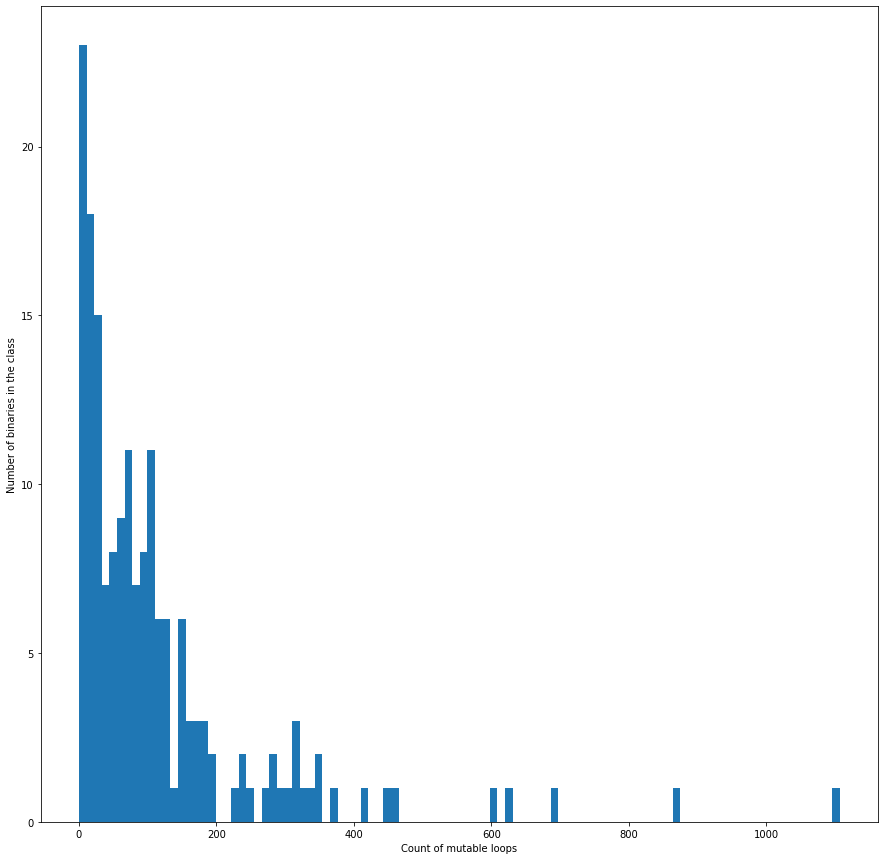

In [10]:
def get_mutable_type_distribution_for_code_motion(bininfo):
    operators_count = bininfo['num_instructions']
    # search the peephole mutation
    loops = 0
    ifs = 0
    
    for m in bininfo['mutations']:
        if 'Codemotion' in m['class_name']:
            for c in m['map'].values():
                for place in c:

                    if 'Invert' in place['how']:
                        ifs += 1
                    if 'Unroll' in place['how']:
                        loops += 1
            break
            
    return loops, ifs


allbins = [  ]

for s in sets:
    if 'Codemotion' in s[0]:
        for b in s[1]:
            allbins.append(b)

mutabilities = [ get_mutable_type_distribution_for_code_motion(b) for b in allbins ]

print(len(mutabilities))
plt.hist([x[0] for x in mutabilities], bins=100)
plt.xlabel("Count of mutable loops")
plt.ylabel("Number of binaries in the class")

print("No mutable at all", len([_ for x in mutabilities if x[0] == 0 and x[1] == 0]))
print("No mutable loops", len([_ for x in mutabilities if x[0] == 0 ]))
print("No mutable ifs", len([_ for x in mutabilities if x[1] == 0 ]))



As expected, there are many more loops than ifs. THe reason is that if constructions are really uncommon un Wasm. Instead, select is used since in the majority of the cases the blocks return a type. **TODO**, check for type returning blocks in all binaries

Text(0, 0.5, 'Number of binaries in the class')

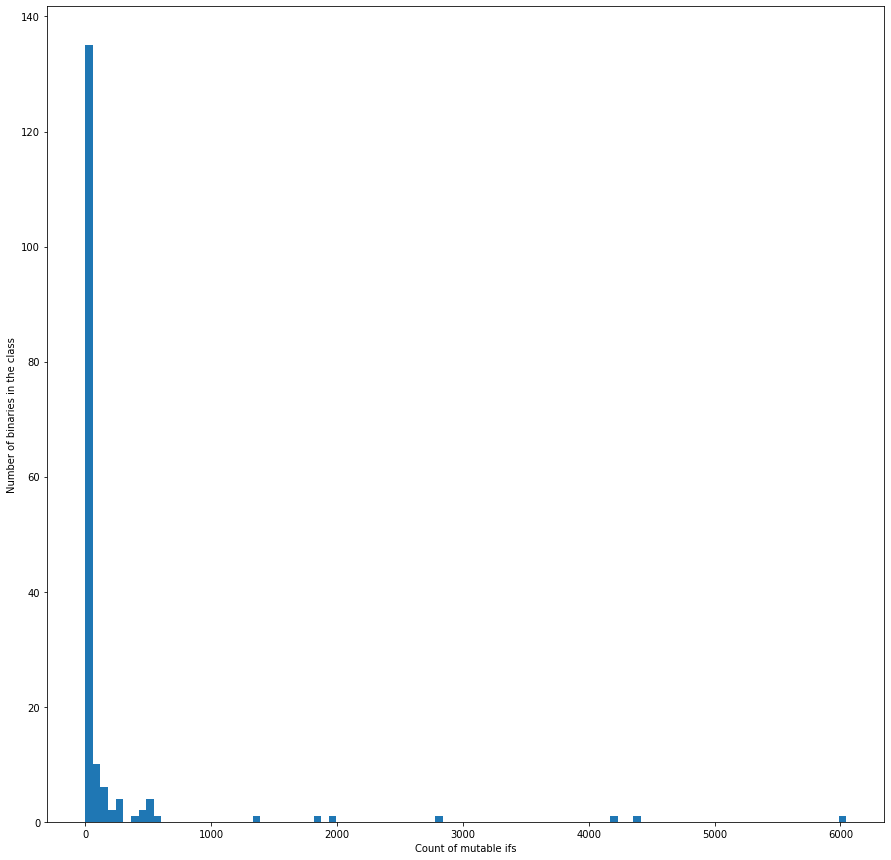

In [11]:

plt.hist([x[1] for x in mutabilities], bins=100)
plt.xlabel("Count of mutable ifs")
plt.ylabel("Number of binaries in the class")

Text(0, 0.5, 'Number of binaries in the class')

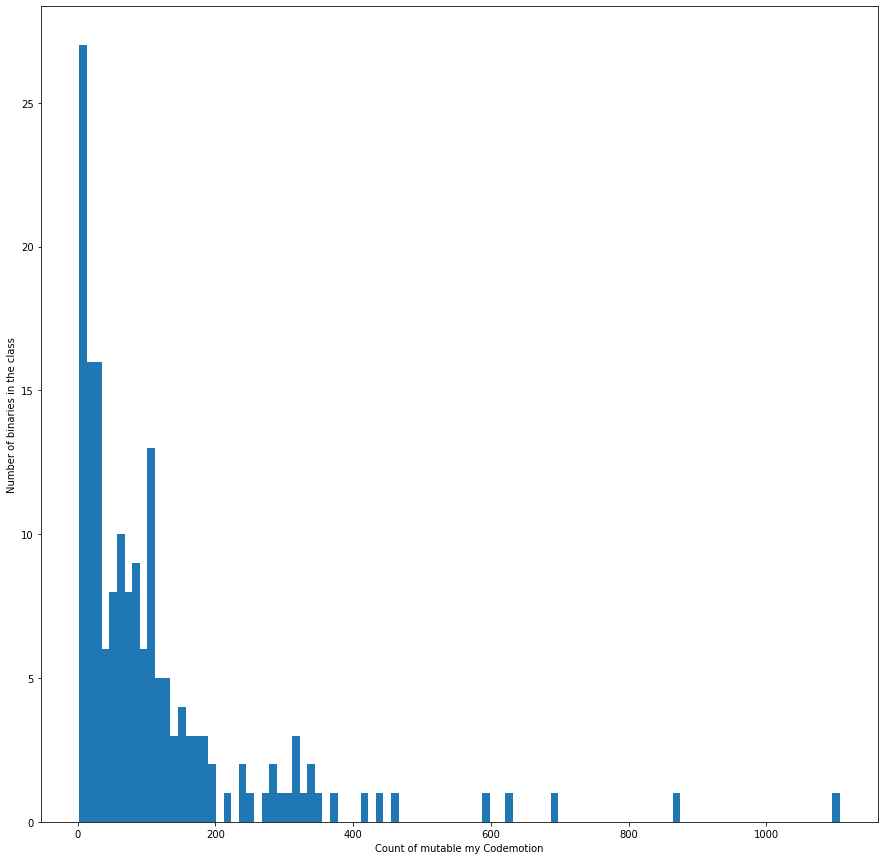

In [12]:

plt.hist([x[0] if x[0] > 0 else x[1] for x in mutabilities], bins=100)
plt.xlabel("Count of mutable my Codemotion")
plt.ylabel("Number of binaries in the class")

## Egraph stats

(array([93.,  8., 17., 26., 16.,  7.,  4.,  3.,  2.,  2.]),
 array([ 10. ,  25.1,  40.2,  55.3,  70.4,  85.5, 100.6, 115.7, 130.8,
        145.9, 161. ]),
 <BarContainer object of 10 artists>)

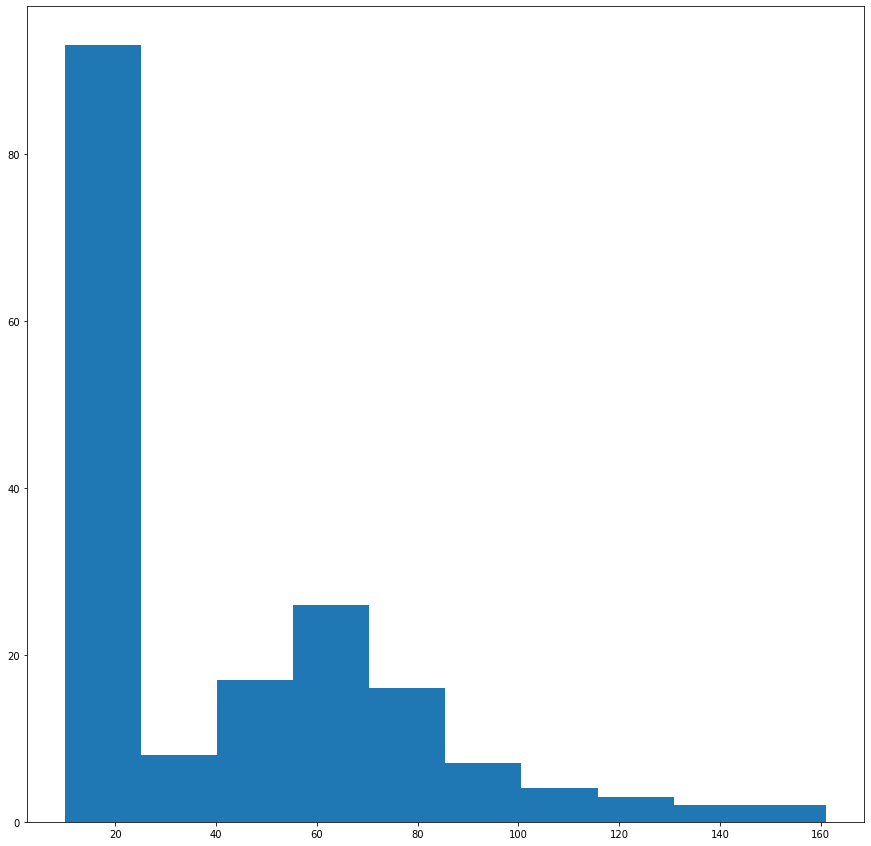

In [13]:
# get some stats on the egraphs of instructions
# get some stats on the profiling of mutable instructions. How many of the specification are we covering ?

# get all posible peephole_mutations for this binary, in this function
def get_egraphs_data(bininfo, key='Peephole'):
    operators_count = bininfo['num_instructions']
    # search the peephole mutation
    egraph_nodes = 0
    egraph_eclasses = 0
    
    for m in bininfo['mutations']:
        if key in m['class_name']:
            if len(m['map']) == 2:
                mutations_count = m['map'][0]
            else:
                for places in m['map'].values():
                    for place in places:
                        # print(place['meta'])
                        egraph_nodes = int(place['meta']['egraph_node_count'])
                        egraph_eclasses = int(place['meta']['egraph_eclass_count'])
            break
            

    return egraph_nodes, egraph_eclasses


allbins = [  ]

for s in sets:
    if 'Peephole' in s[0]:
        for b in s[1]:
            allbins.append(b)
            
egraphs_datas = [ get_egraphs_data(b) for b in allbins ]
xs = sorted([x[0] for x in egraphs_datas])
# Plot distribution of egraph node count
plt.hist(xs)


(array([ 1., 12., 83., 16., 30., 15.,  7.,  4.,  3.,  7.]),
 array([ 5. ,  6.1,  7.2,  8.3,  9.4, 10.5, 11.6, 12.7, 13.8, 14.9, 16. ]),
 <BarContainer object of 10 artists>)

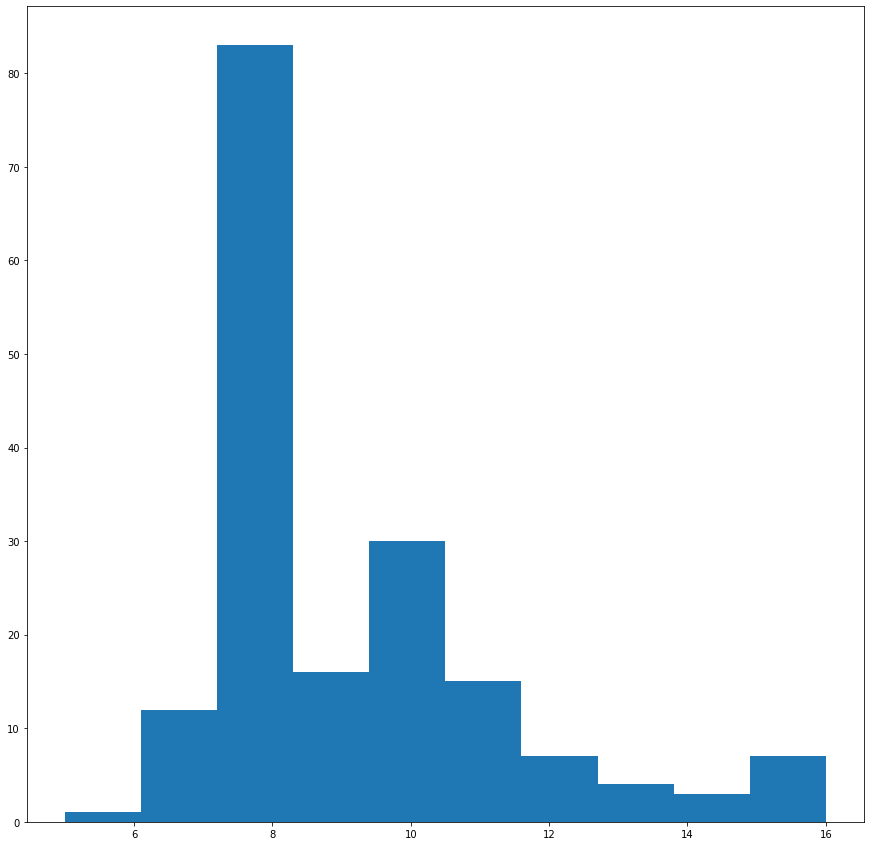

In [14]:

# Plot distribution of egraph eclass count
plt.hist([x[1] for x in egraphs_datas])